# Strain map of a transistor

The `libertem.udf.blobfinder`, `libertem.analysis.gridmatching` and `libertem.analysis.fullmatch` modules of LiberTEM allow to find and trace the position of CBED diffraction disks, and to derive grid parameters. These grid parameters can be used to determine lattice strain.

The sample is a dummy transistor with a SiN gate and recessed SiGe source/drain. The SiGe source/drain are used to introduce a compression of the Si channel. 

Sample data: Thibaud Denneulin, ER-C Forschungszentrum Jülich

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
from matplotlib import cm
import skimage

In [4]:
import libertem.api as lt
import libertem.udf.blobfinder as blb
import libertem.analysis.gridmatching as grm
import libertem.udf.logsum as logsum
# fullmatch requires hdbscan, which is an optional dependency
import libertem.analysis.fullmatch as fm
import libertem.masks as masks

Using a descriptor dictionary allows to implement batch processing of many files more easily.

In [5]:
descriptors = [
    {'path': r'/cachedata/users/weber/data/thibaud/2018-10-26_SiGe-transistor/Capture93_.gtg', 'r': 80.0},
]

In [6]:
ctx = lt.Context()

## Opening files and determining basic parameters

In [7]:
for d in descriptors:
    d['dirname'] = os.path.dirname(os.path.abspath(d['path']))
    d['base'], _ = os.path.splitext(os.path.basename(d['path']))
    d['ds'] = ctx.load('K2IS', path=d['path'])
    d['y'], d['x'] = d['ds'].shape.nav
    d['fy'], d['fx'] = d['ds'].shape.sig

## Logsum frame

We calculate the sum of all log-scaled frames to generate a good overview map. This highlights peaks that are realtively weak, but present on many frames.

In [8]:
for d in descriptors:
    print("Logsum of ", d['path'])
    # Sum of log-scaled frames, which highlights weak peaks that are present in many frames
    d['logsum'] = logsum.run_logsum(ctx, d['ds'])['logsum'].data

Logsum of  /cachedata/users/weber/data/thibaud/2018-10-26_SiGe-transistor/Capture93_.gtg


## Determine base lattice
The `fullmatch` module allows to guess grid parameters to match peak positions with a parallelogram lattice.

In [9]:
peakfind_params = dict(
    padding=0.1,
    mask_type='radial_gradient',
    tolerance=7,
)

for d in descriptors:
    try:
        print("Matching ", d['path'])
        peakfind_params['radius'] = d['r']
        # A fairly low number of disks works well since the lattice is very simple
        # and large CBED disks can easily lead to errorneous results inbetween the gaps.
        peakfind_params['num_disks'] = d.get('num_disks', 5)
        # Find peaks in the logsum frame
        d['found_peaks'] = blb.get_peaks(parameters=peakfind_params, sum_result=d['logsum'])
        # Find lattice match for peaks from scratch
        # This doesn't take into account the 3D crystal structure of the sample,
        # but works puerly within the 2D geometry of the detector
        (d['matches'], d['unmatched'], d['weak']) = fm.full_match(d['found_peaks'])
    except Exception as e:
        print(repr(e))

Matching  /cachedata/users/weber/data/thibaud/2018-10-26_SiGe-transistor/Capture93_.gtg


In this case, the zero order peak was not the most intense peak. For that reason we patch the result by shifting it and ajusting the indices.

In [10]:
for d in descriptors:
    m = d['matches'][0]
    m.zero += m.a
    m.indices[:, 0] -= 1

We visualize the logsum frame, the peaks and the match.

<IPython.core.display.Javascript object>


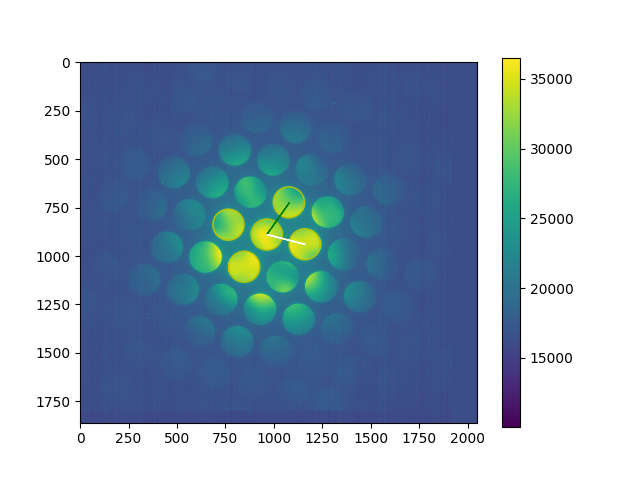

In [11]:
for d in descriptors:
    try:
        # Visualize found peaks and lattice match
        fig, axes = plt.subplots()
        pcm = axes.imshow(d['logsum'])

        fig.colorbar(pcm, ax=axes)

        
        for p in np.flip(d['found_peaks'], axis=1):
            axes.add_artist(plt.Circle(p, d['r'], color="y", fill=False))


        axes.arrow(*np.flip(m.zero), *(np.flip(m.a)), color='g')
        axes.arrow(*np.flip(m.zero), *(np.flip(m.b)), color='w')

        fig.savefig(d['dirname'] + '/%s-logsum_frame.svg' % d['base'])
    except Exception as e:
        print(e)

We earmark a frame to serve as a reference for fine-adjustment of the template

In [12]:
descriptors[0]['ref_y'] = 17
descriptors[0]['ref_x'] = 49

## Adjust matching template
The data was recorded at fairly high detector resolution and the bright field disk is slightly distorted. In order to get the optimal fit quality, the template is tuned by hand to match the CBED disk as precisely as possible.

See also https://github.com/LiberTEM/LiberTEM/issues/395

<IPython.core.display.Javascript object>


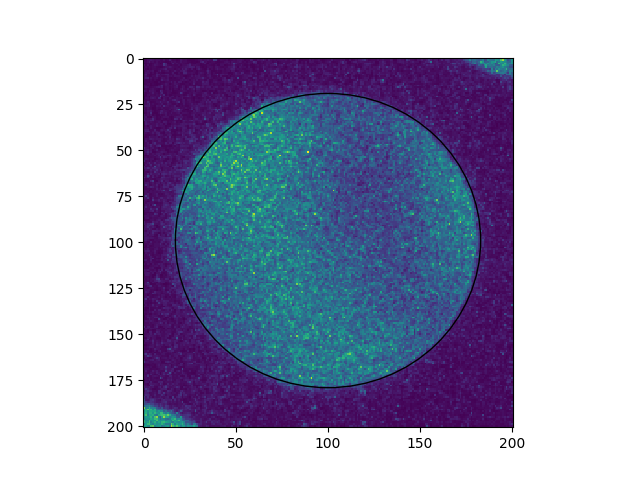

<IPython.core.display.Javascript object>


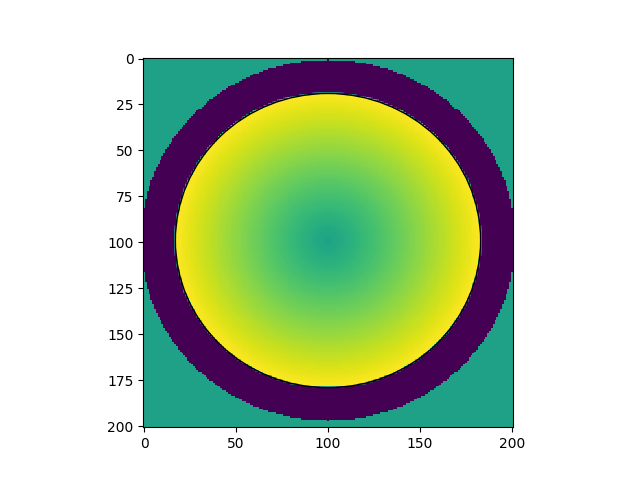

In [13]:
for d in descriptors:
    pick_j = ctx.create_pick_job(dataset=d['ds'], origin=(d['ref_y'], d['ref_x']))
    res = ctx.run(pick_j)
    cy, cx = np.round(d['matches'][0].zero).astype(np.int)
    rr = int(np.ceil(d['r']))
    sample = res[cy-rr-20:cy+rr+21, cx-rr-20:cx+rr+21]
    fig, axes = plt.subplots()
    axes.imshow(sample)
    p = ptch.Ellipse((rr+20, rr+19), width=2*rr+6, height=2*rr, angle=0, fill=False)
    axes.add_patch(p)
    
    radius, phi = masks.polar_map(
        centerX=rr+20, centerY=rr+19, imageSizeX=sample.shape[1], imageSizeY=sample.shape[0],
        stretchY=(2*rr + 6)/(2*rr),
        angle=np.pi/2
    )
    template = masks.radial_gradient_background_subtraction(
        r=radius,
        r0=d['r'],
        r_outer=rr+18,
    )
    template = masks.balance(template)
    fig, axes = plt.subplots()
    axes.imshow(template)
    p = ptch.Ellipse((rr+20, rr+19), width=2*rr+6, height=2*rr, angle=0, fill=False)
    axes.add_patch(p)
    d['template'] = template


We compare the shape over a number of frames from different positions in the scan. Note how the CBED disk has slightly varying shape. https://github.com/LiberTEM/LiberTEM/issues/395

<IPython.core.display.Javascript object>


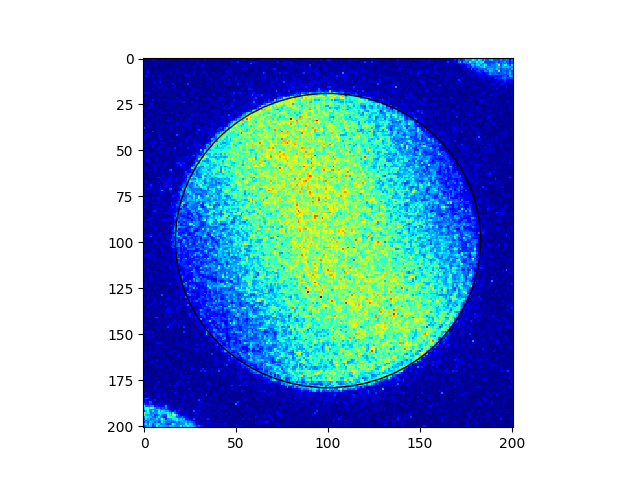

<IPython.core.display.Javascript object>


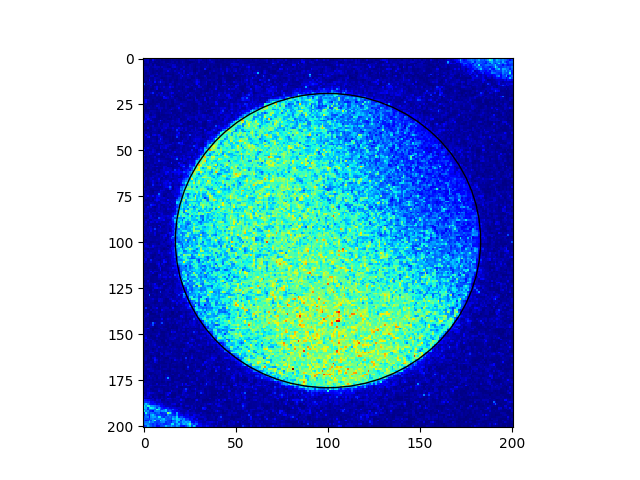

<IPython.core.display.Javascript object>


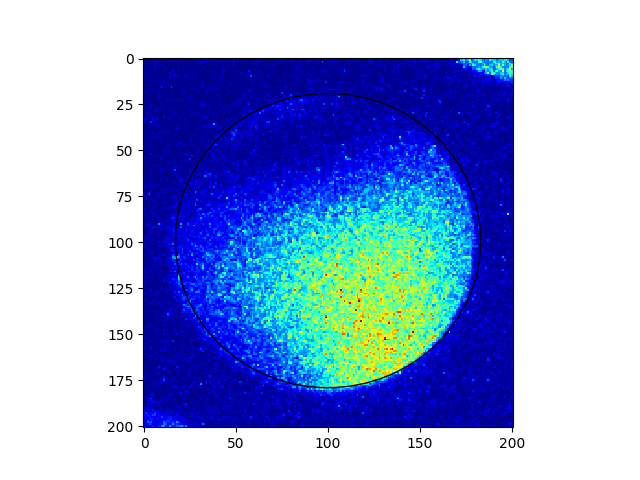

<IPython.core.display.Javascript object>


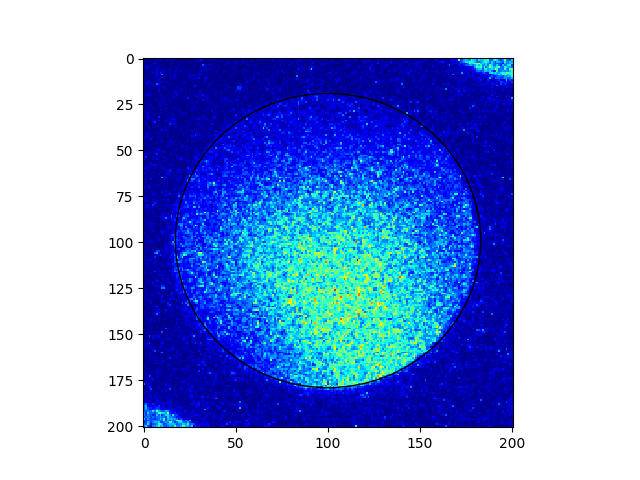

In [14]:
for d in descriptors:
    for coords in [(1, 1), (1, d['x']-2), (d['y']-2, 1), (d['y']-2, d['x']-2)]:
        pick_j = ctx.create_pick_job(dataset=d['ds'], origin=coords)
        res = ctx.run(pick_j)
        cy, cx = np.round(d['matches'][0].zero).astype(np.int)
        rr = int(np.ceil(d['r']))
        sample = res[cy-rr-20:cy+rr+21, cx-rr-20:cx+rr+21]
        fig, axes = plt.subplots()
        axes.imshow(sample, cmap=cm.jet)
        p = ptch.Ellipse((rr+20, rr+19), width=2*rr+6, height=2*rr, angle=0, fill=False)
        axes.add_patch(p)

## Refine the lattice

Now we refine the lattice parameters for each frame using our custom template.

In [15]:
%%time
peakfind_params['min_weight'] = 1
peakfind_params['mask_type'] = 'template'
for d in descriptors:
    peakfind_params['template'] = d['template']
    print("Refining ", d['path'])
    peakfind_params['radius'] = d['r']
    m = d['matches'][0]
    # Refine the lattice parameters for each frame
    d['match'], d['indices'] = blb.run_refine(
        ctx=ctx,
        dataset=d['ds'],
        zero=m.zero,
        a=m.a,
        b=m.b,
        indices=np.mgrid[-3:4, -3:4],
        params=peakfind_params
    )

Refining  /cachedata/users/weber/data/thibaud/2018-10-26_SiGe-transistor/Capture93_.gtg
CPU times: user 30.4 s, sys: 5.45 s, total: 35.8 s
Wall time: 3min 25s


## Post-processing and visualization

We set some markers and parameters for subsequent batch-oriented visualizations.

In [16]:
descriptors[0].update({    
    'markers': [
        {'label': 'A', 'y': 8, 'x': 16},
        {'label': 'B', 'y': 8, 'x': 90},
        {'label': 'C', 'y': 4, 'x': 50},
        {'label': 'D', 'y': 50, 'x': 50},
    ],
    'comparison': {'y1': 8, 'x1': 16, 'y2': 50,'x2': 50},
})

We do some postprocessing, most importantly converting to polar coordinates to compare lengths and angles.

In [17]:
for d in descriptors:
    match = d['match']
    d['zeros'] = match['zero'].data
    d['aas'] = match['a'].data
    d['bbs'] = match['b'].data
    d['polar_zeros'] = grm.make_polar(match['zero'].data)
    d['polar_aas'] = grm.make_polar(match['a'].data)
    d['polar_bbs'] = grm.make_polar(match['b'].data)

In [18]:
def mark(axes, markers):
    for m in markers:
        axes.text(
            m['x'], m['y'], m['label'], 
            bbox={'boxstyle': 'circle', 'fc': (1, 1, 1, 0.5)},
            ha="center",
            va="center"
        )

This is an overview frame with the marker positions

<IPython.core.display.Javascript object>


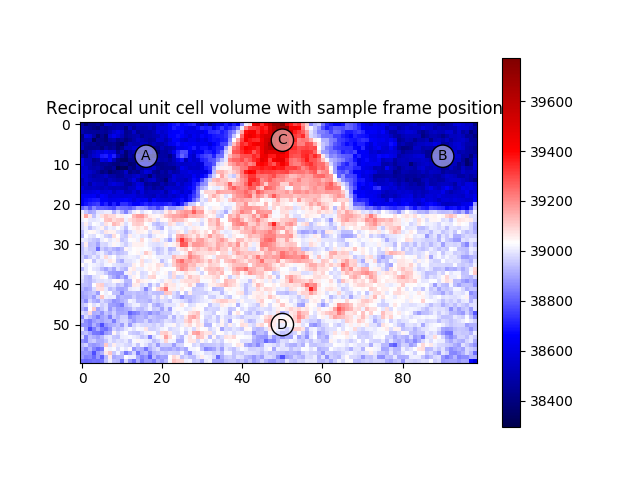

In [19]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(
        d['polar_aas'][:, :, 0] *\
        d['polar_bbs'][:, :, 0] *\
        np.abs(np.sin(d['polar_aas'][:, :, 1] - d['polar_bbs'][:, :, 1])),
        cmap=cm.seismic,
    )
    if 'markers' in d:
        mark(axes, d['markers'])

    fig.colorbar(pcm, ax=axes)
    plt.title("Reciprocal unit cell volume with sample frame positions")

<IPython.core.display.Javascript object>


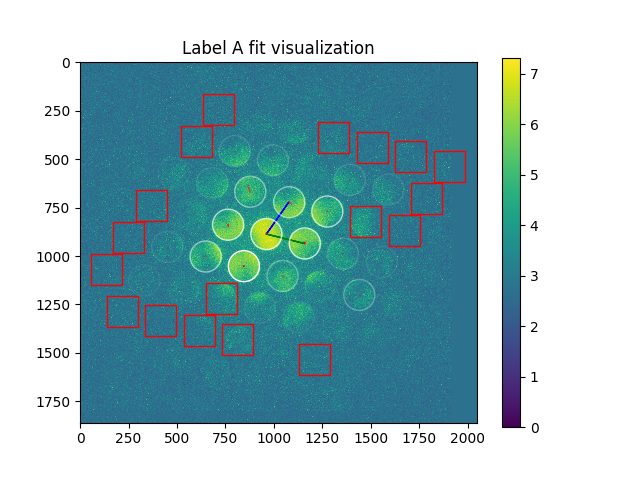

<IPython.core.display.Javascript object>


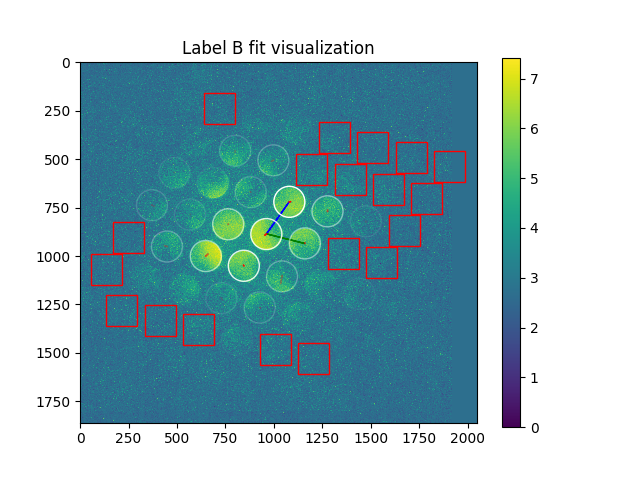

<IPython.core.display.Javascript object>


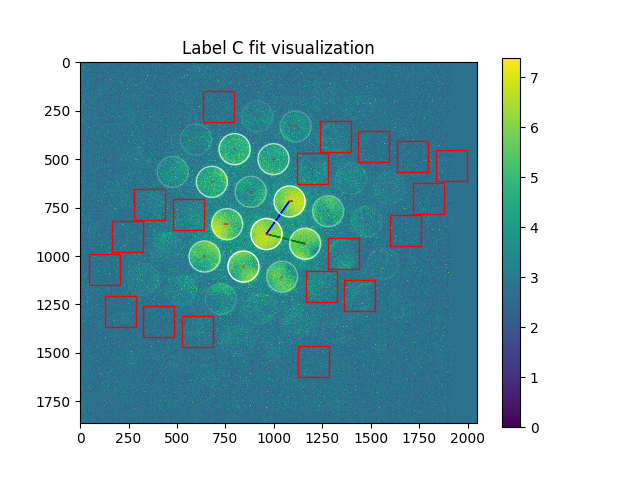

<IPython.core.display.Javascript object>


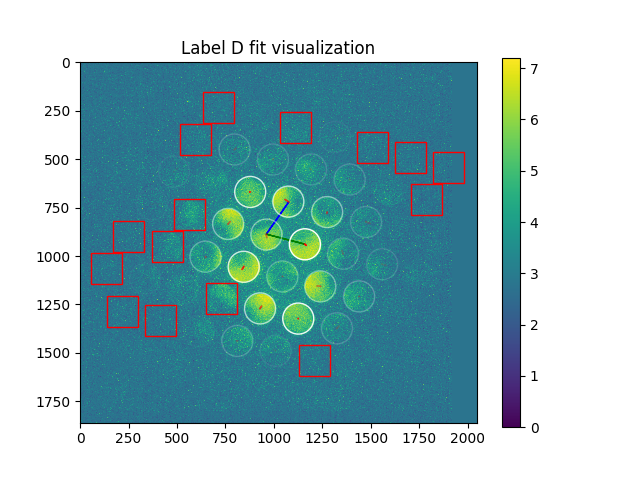

In [20]:
for d in descriptors:
    if 'markers' in d:
        for m in d['markers']:
            # Visualize the refinement of a specific frame
            fig, axes = plt.subplots()

            pcm = blb.visualize_frame(
                ctx, d['ds'],
                result=d['match'],
                indices=d['indices'],
                r=d['r'],
                y=m['y'],
                x=m['x'],
                axes=axes
            )

            fig.colorbar(pcm, ax=axes)
            plt.title("Label %s fit visualization" % m['label'])

<IPython.core.display.Javascript object>


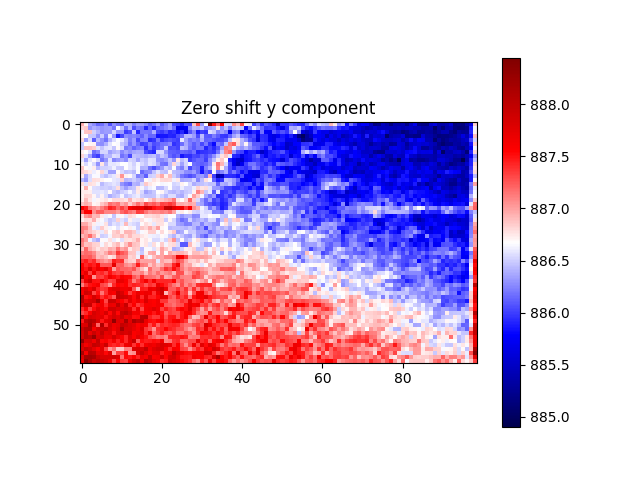

In [21]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['zeros'][:, :, 0], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Zero shift y component")

<IPython.core.display.Javascript object>


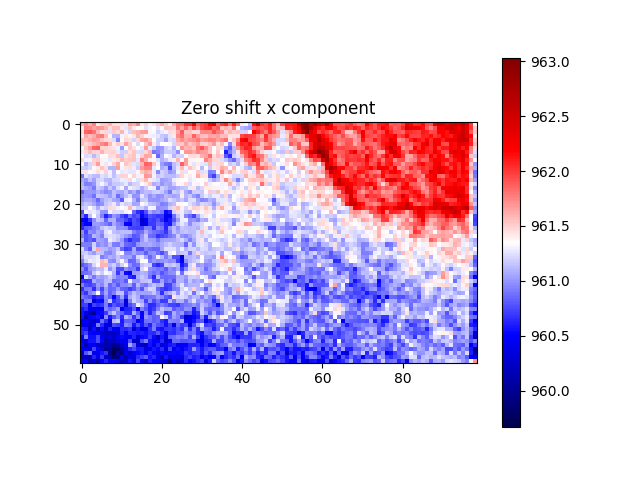

In [22]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['zeros'][:, :, 1], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Zero shift x component")

<IPython.core.display.Javascript object>


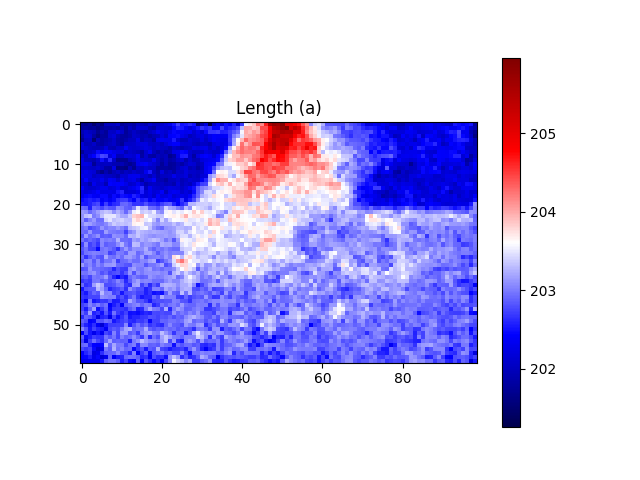

In [23]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['polar_aas'][:, :, 0], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Length (a)")

<IPython.core.display.Javascript object>


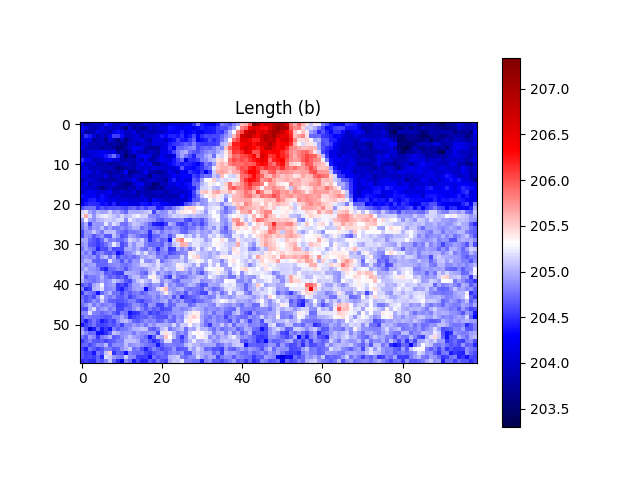

In [24]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['polar_bbs'][:, :, 0], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Length (b)")

<IPython.core.display.Javascript object>


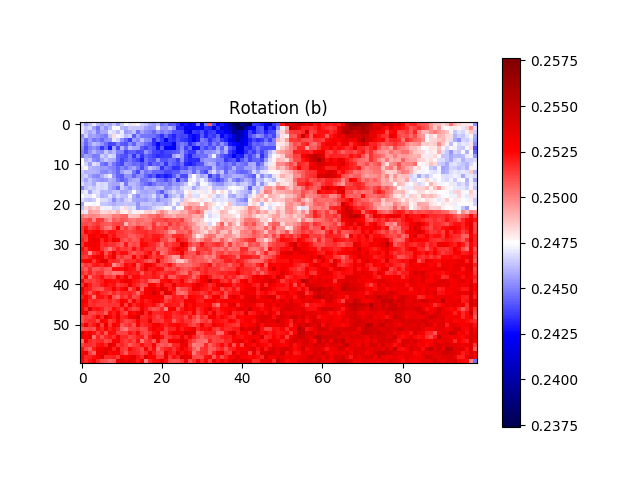

In [25]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['polar_bbs'][:, :, 1], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Rotation (b)")

<IPython.core.display.Javascript object>


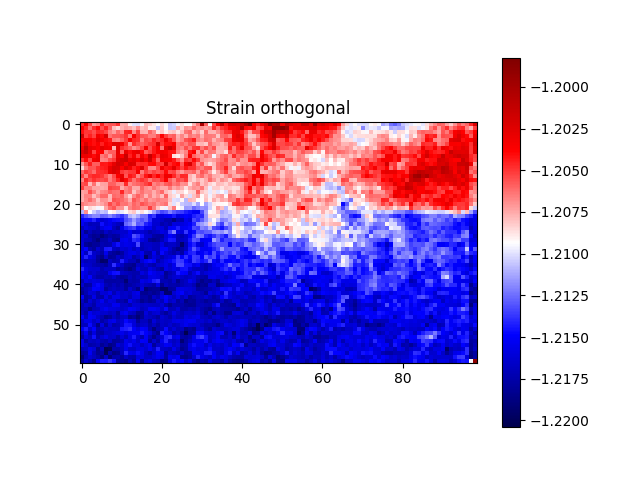

In [26]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['polar_aas'][:, :, 1] - d['polar_bbs'][:, :, 1], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Strain orthogonal")

<IPython.core.display.Javascript object>


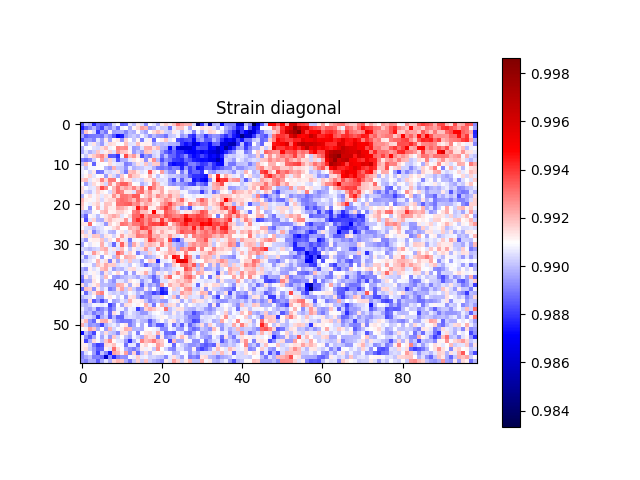

In [27]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['polar_aas'][:, :, 0] / d['polar_bbs'][:, :, 0], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Strain diagonal")

<IPython.core.display.Javascript object>


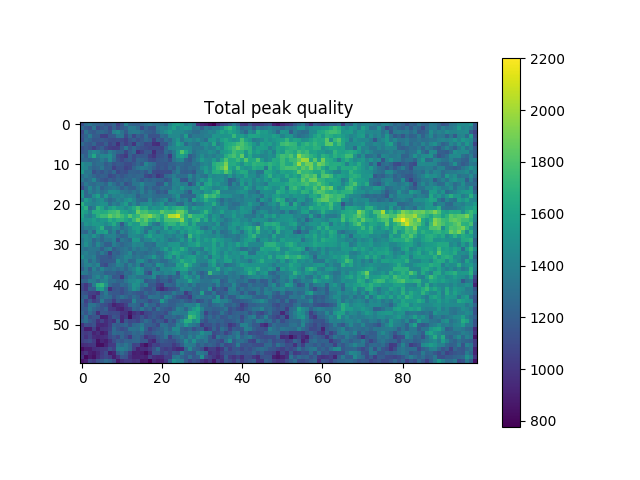

In [28]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(
        d['match']['peak_elevations'].data.sum(axis=-1)
    )
    fig.colorbar(pcm, ax=axes)
    plt.title("Total peak quality")

/cachedata/users/weber/libertem-uellue-venv/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


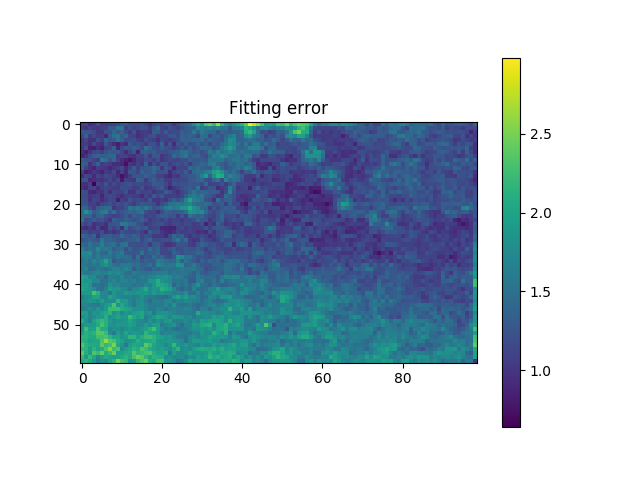

In [29]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(match['error'].data)
    fig.colorbar(pcm, ax=axes)
    plt.title("Fitting error")